In [206]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import normalize


import os
import pathlib
import sys
import matplotlib.pyplot as plt
from scipy import linalg


sys.path.append(os.path.join(pathlib.Path(os.getcwd()).parent))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils.bq_conn import bq_conn_file
# %%
bq_client = bq_conn_file(project_id="dsa-miad-365616")

In [207]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
#print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)





,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,departamento_ejecucion,numero_de_proceso,numero_de_contrato,cuantia_proceso,id_grupo,nombre_grupo,id_familia,nombre_familia,id_clase,nombre_clase,id_adjudicacion,tipo_identifi_del_contratista,identificacion_del_contratista,nom_razon_social_contratista,tipo_doc_representante_legal,identific_representante_legal,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,cundinamarca,CPMMSFFAMCNo01DE2019,CPMMSFFAMCNO01DE2019,50000000,E,productos de uso final,5022,productos de cereales legumbres,502213,harina productos de molinos,8143424,nit de persona juridica,900791326,inversiones ocazo,cedula de ciudadania,1022363447,330,330,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA184DE2019,184DE2019,22980096902,E,productos de uso final,5310,ropa,531027,uniformes,9226352,nit de persona juridica,860020227,fondo rotatorio de la policia forpo,nit de persona juridica,860020227,660,690,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA188DE2019,188DE2019,35998452,E,productos de uso final,5510,medios impresos,551015,publicaciones impresas,9265538,nit de persona juridica,830001113,imprenta nacional de colombia,nit de persona juridica,830001113,31,71,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA106DE2019,106DE2019,16767536,F,servicios,7210,servicios de mantenimiento reparaciones de con...,721015,servicios de apoyo para la construccion,8644918,nit de persona juridica,860025639,mitsubishi electric de colombia limitada,nit de persona juridica,860025639,170,170,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,bogota,CONVENIODEASOCIACIÓN231DE2018,231DE2018,0,F,servicios,7318,servicios de maquinado procesado,731810,servicios de maquinado,8059861,nit de persona juridica,806011019,recuperaciones naranjo recycling sas,cedula de ciudadania,57439563,360,360,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


In [208]:
secopI_filter = secop_I[
    ['id_modalidad', 'estado_del_proceso', 'id_objeto_a_contratar', 'tipo_de_contrato', 'departamento_ejecucion',
     'municipios_ejecucion_', 'cuantia_proceso', 'id_grupo',
     'id_familia', 'id_clase', 'plazo_de_ejec_del_contrato_', 'tiempo_adiciones_en_dias', 'dias_ejec_final_contrato']]

secopI_filter
secopI_filter.columns
base = secopI_filter
n = base.isna() == True
base = base.fillna(0)
base.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id_modalidad                 26553 non-null  Int64 
 1   estado_del_proceso           26553 non-null  object
 2   id_objeto_a_contratar        26553 non-null  Int64 
 3   tipo_de_contrato             26553 non-null  object
 4   departamento_ejecucion       26553 non-null  object
 5   municipios_ejecucion_        26553 non-null  object
 6   cuantia_proceso              26553 non-null  Int64 
 7   id_grupo                     26553 non-null  object
 8   id_familia                   26553 non-null  object
 9   id_clase                     26553 non-null  object
 10  plazo_de_ejec_del_contrato_  26553 non-null  Int64 
 11  tiempo_adiciones_en_dias     26553 non-null  Int64 
 12  dias_ejec_final_contrato     26553 non-null  Int64 
dtypes: Int64(6), object(7)
memory u

In [209]:
# Codificación de las variables categoricas
base['estado_del_proceso'] = pd.factorize(base.estado_del_proceso)[0]
base['tipo_de_contrato'] = pd.factorize(base.tipo_de_contrato)[0]
base['departamento_ejecucion'] = pd.factorize(base.departamento_ejecucion)[0]
base['municipios_ejecucion_'] = pd.factorize(base.municipios_ejecucion_)[0]
base['id_grupo'] = pd.factorize(base.id_grupo)[0]
base['id_familia'] = pd.factorize(base.id_familia)[0]
base['id_clase'] = pd.factorize(base.id_clase)[0]
base['plazo_de_ejec_del_contrato_'] = pd.factorize(base.plazo_de_ejec_del_contrato_)[0]

In [210]:
df = base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   id_modalidad                 26553 non-null  Int64
 1   estado_del_proceso           26553 non-null  int64
 2   id_objeto_a_contratar        26553 non-null  Int64
 3   tipo_de_contrato             26553 non-null  int64
 4   departamento_ejecucion       26553 non-null  int64
 5   municipios_ejecucion_        26553 non-null  int64
 6   cuantia_proceso              26553 non-null  Int64
 7   id_grupo                     26553 non-null  int64
 8   id_familia                   26553 non-null  int64
 9   id_clase                     26553 non-null  int64
 10  plazo_de_ejec_del_contrato_  26553 non-null  int64
 11  tiempo_adiciones_en_dias     26553 non-null  Int64
 12  dias_ejec_final_contrato     26553 non-null  Int64
dtypes: Int64(5), int64(8)
memory usage: 2.8 MB


In [211]:
from sklearn.model_selection import train_test_split

y_total = df.loc[:, df.columns == "tiempo_adiciones_en_dias"]
X_total = df.loc[:, df.columns != "tiempo_adiciones_en_dias"]
y_total = y_total.reset_index(drop=True)

# Reparto de datos en train y test
y_totalf = y_total.tiempo_adiciones_en_dias.tolist()
X_train, X_test, y_train, y_test = train_test_split(X_total, y_totalf, test_size=0.33, random_state=1)


<Axes: >

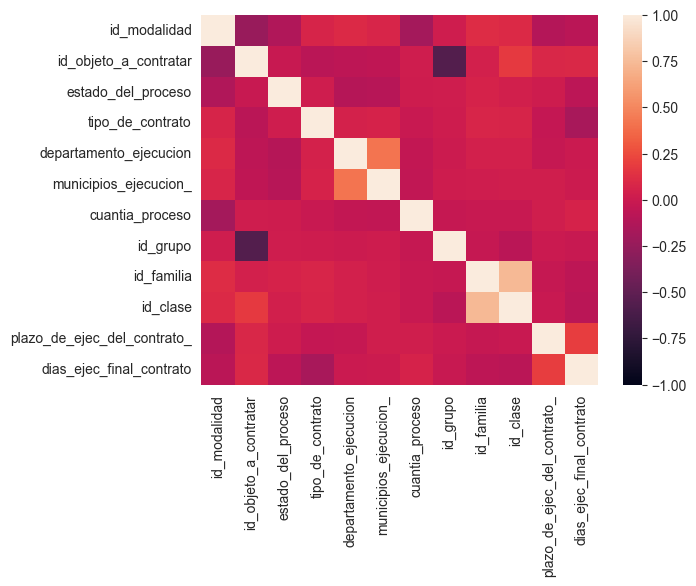

In [212]:
import seaborn as sns
sns.heatmap(X_total[["id_modalidad", "id_objeto_a_contratar", "estado_del_proceso", "tipo_de_contrato", "departamento_ejecucion","municipios_ejecucion_","cuantia_proceso","id_grupo","id_familia", "id_clase","plazo_de_ejec_del_contrato_", "dias_ejec_final_contrato" ]].corr(), vmin=-1, vmax=1, annot=False)


In [213]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [214]:
train_stats = train_dataset.describe()
train_stats.pop("tiempo_adiciones_en_dias")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
id_modalidad,21242.0,12.850909,0.537507,1.0,13.0,13.0,13.0,19.0
estado_del_proceso,21242.0,0.666651,0.867649,0.0,0.0,0.0,1.0,6.0
id_objeto_a_contratar,21242.0,47790603.521326,19854229.145802,10000000.0,44000000.0,50000000.0,53000000.0,95000000.0
tipo_de_contrato,21242.0,2.136098,2.327779,0.0,0.0,1.0,5.0,9.0
departamento_ejecucion,21242.0,8.671924,6.699319,0.0,3.0,8.0,12.0,30.0
municipios_ejecucion_,21242.0,46.552208,40.594633,0.0,10.0,36.0,78.0,227.0
cuantia_proceso,21242.0,19836893.112607,178561205.183926,0.0,1500000.0,4522639.0,16000000.0,22980096902.0
id_grupo,21242.0,1.139488,1.814365,0.0,0.0,0.0,1.0,6.0
id_familia,21242.0,75.602486,63.051993,0.0,37.0,50.0,92.0,299.0
id_clase,21242.0,205.27987,205.354927,0.0,63.0,89.0,378.0,958.0


In [215]:
train_labels = train_dataset.pop('tiempo_adiciones_en_dias')
test_labels = test_dataset.pop('tiempo_adiciones_en_dias')

In [216]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [223]:
def build_model ():
  model = keras.Sequential([
    layers.Dense(13, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(6, activation='linear'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [224]:
model = build_model()

In [225]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 13)                169       
                                                                 
 dense_51 (Dense)            (None, 6)                 84        
                                                                 
 dense_52 (Dense)            (None, 1)                 7         
                                                                 
Total params: 260 (1.02 KB)
Trainable params: 260 (1.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [226]:
train_data = np.asarray(normed_train_data).astype(np.float32)
test_data = np.asarray(normed_test_data).astype(np.float32)


In [227]:
example_batch = np.array(train_data[:])
example_result = model.predict(example_batch)
example_result

664/664 [==============================] - 0s 338us/step


array([[0.7590749 ],
       [0.3026478 ],
       [1.0061352 ],
       ...,
       [0.5902995 ],
       [0.20613012],
       [0.15440425]], dtype=float32)

In [232]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 300

from keras import backend as K
train_data = K.cast_to_floatx(train_data)
train_labels = K.cast_to_floatx(train_labels)

history = model.fit(
   train_data,
    train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................

In [233]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist)

          loss       mae        mse   val_loss   val_mae    val_mse  epoch
0    73.144516  2.337508  73.144516  83.028282  2.561514  83.028282      0
1    75.215469  2.346267  75.215469  84.960556  2.530307  84.960556      1
2    73.839027  2.350215  73.839027  83.705620  2.357784  83.705620      2
3    76.734680  2.324940  76.734680  82.297783  2.375553  82.297783      3
4    74.892784  2.336741  74.892784  82.461540  2.415999  82.461540      4
..         ...       ...        ...        ...       ...        ...    ...
295  61.845261  2.184579  61.845261  78.543495  2.432696  78.543495    295
296  64.002281  2.158353  64.002281  79.248428  2.410216  79.248428    296
297  65.905449  2.176647  65.905449  78.370583  2.210331  78.370583    297
298  65.445831  2.174632  65.445831  78.911263  2.460319  78.911263    298
299  62.563892  2.182632  62.563892  78.994850  2.220755  78.994850    299

[300 rows x 7 columns]


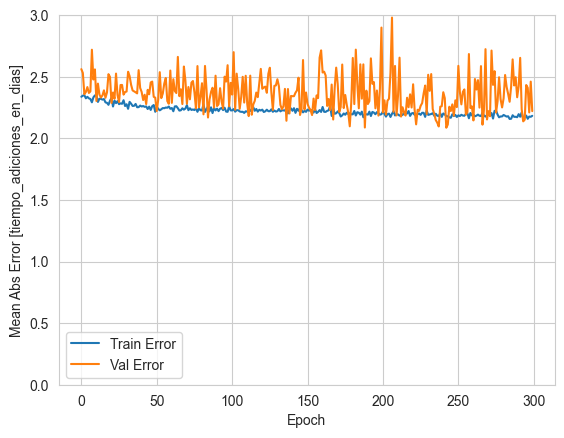

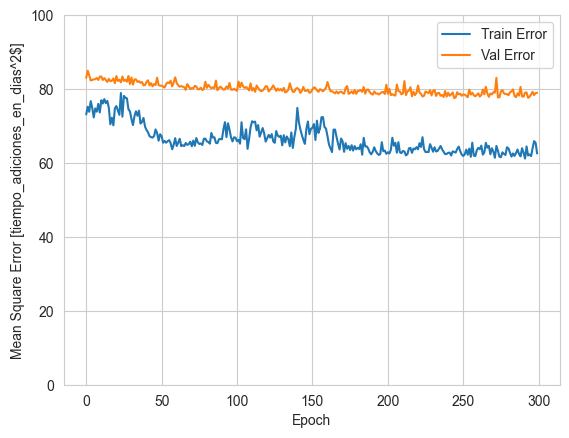

In [234]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [tiempo_adiciones_en_dias]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,3])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [tiempo_adiciones_en_dias^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,100])
  plt.legend()
  plt.show()


plot_history(history)